## Get Data

In [1]:
!wget -P /content/data/ https://zenodo.org/record/1322001/files/test_set.zip?download=1

--2020-10-14 05:18:55--  https://zenodo.org/record/1322001/files/test_set.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43751086 (42M) [application/octet-stream]
Saving to: ‘/content/data/test_set.zip?download=1’

test_set.zip?downlo 100%[===================>]  41.72M  7.70MB/s    in 5.9s    

2020-10-14 05:19:03 (7.01 MB/s) - ‘/content/data/test_set.zip?download=1’ saved [43751086/43751086]



In [2]:
!wget -P /content/data/ https://zenodo.org/record/1322001/files/training_set.zip?download=1

--2020-10-14 05:19:03--  https://zenodo.org/record/1322001/files/training_set.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132986834 (127M) [application/octet-stream]
Saving to: ‘/content/data/training_set.zip?download=1’

training_set.zip?do 100%[===================>] 126.83M  6.54MB/s    in 24s     

2020-10-14 05:19:29 (5.36 MB/s) - ‘/content/data/training_set.zip?download=1’ saved [132986834/132986834]



In [3]:
import zipfile
path_to_zip_file='/content/data/test_set.zip?download=1'
directory_to_extract_to='/content/data/'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [4]:
import zipfile
path_to_zip_file='/content/data/training_set.zip?download=1'
directory_to_extract_to='/content/data/'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

## Data Exploration

In the Data exploration subsection, we inspected the data to understand more about it. First,
we got the list of images and annotations in the training_set folder. The annotations files
have the term Annotation in the filename. As we previously learned, there were 999
images and 999 annotation files in the folder.

In [5]:
import os
path2train="./data/training_set/"

imgsList=[pp for pp in os.listdir(path2train) if "Annotation" not in pp]
anntsList=[pp for pp in os.listdir(path2train) if "Annotation" in pp]
print("number of images:", len(imgsList))
print("number of annotations:", len(anntsList))

number of images: 1000
number of annotations: 999


In the Data exploration subsection, we inspected the data to understand more about it. First,
we got the list of images and annotations in the training_set folder. The annotations files
have the term Annotation in the filename. As we previously learned, there were 999
images and 999 annotation files in the folder.

In [6]:
import numpy as np
np.random.seed(2019)
rndImgs=np.random.choice(imgsList,4)
rndImgs

array(['76_2HC.png', '788_HC.png', '482_2HC.png', '185_HC.png'],
      dtype='<U11')

In the function, we used mark_boundaries from the skimage.segmentation package to
overlay the mask on the image.


In [7]:
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch

def show_img_mask(img, mask):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        mask=to_pil_image(mask)
        
    img_mask=mark_boundaries(np.array(img), 
                        np.array(mask),
                        outline_color=(0,1,0),
                        color=(0,1,0))
    plt.imshow(img_mask)
    

Note that the annotation files contain the edges of the fetal head. As such,
we converted the edges to binary masks using the binary_fill_holes
function from the scipy.ndimage package. The screenshot displayed
original ultrasound images on the left, binary masks of the fetal heads in
the middle, and the image overlay on the right

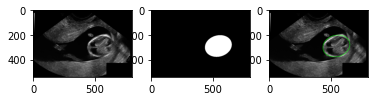

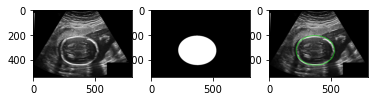

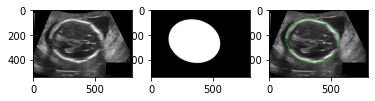

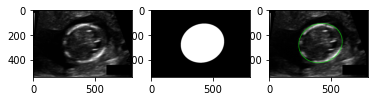

In [8]:

for fn in rndImgs:
    path2img = os.path.join(path2train, fn)
    path2annt= path2img.replace(".png", "_Annotation.png")
    img = Image.open(path2img)
    annt_edges = Image.open(path2annt)
    mask = ndi.binary_fill_holes(annt_edges)        

    plt.figure()
    plt.subplot(1, 3, 1) 
    plt.imshow(img, cmap="gray")

    plt.subplot(1, 3, 2) 
    plt.imshow(mask, cmap="gray")

    plt.subplot(1, 3, 3) 
    show_img_mask(img, mask)
    

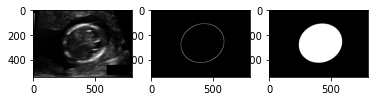

In [9]:

path2img = os.path.join(path2train, fn)
path2annt= path2img.replace(".png", "_Annotation.png")
img = Image.open(path2img)
annt_edges = Image.open(path2annt)
mask = ndi.binary_fill_holes(annt_edges) 
plt.figure()
plt.subplot(1, 3, 1) 
plt.imshow(img, cmap="gray")

plt.subplot(1, 3, 2) 
plt.imshow(annt_edges, cmap="gray")

plt.subplot(1, 3, 3) 
plt.imshow(mask, cmap="gray")
#Note that the annotation files contain the edges of the fetal head. As such, we converted the
#edges to binary masks using the binary_fill_holes function from the scipy.ndimage package

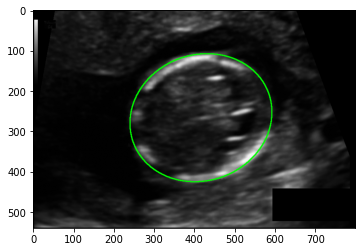

In [10]:
plt.subplot(1, 1, 1) 
show_img_mask(img, mask)

(-0.5, 799.5, 539.5, -0.5)

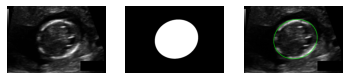

In [11]:
plt.figure()
plt.subplot(1, 3, 1) 
plt.imshow(img, cmap="gray")
plt.axis('off')

plt.subplot(1, 3, 2) 
plt.imshow(mask, cmap="gray")
plt.axis('off')    

plt.subplot(1, 3, 3) 
show_img_mask(img, mask)
plt.axis('off')


Data augmentation

In the Data augmentation subsection, we used a popular Python package called
albumentations for data transformation. For the first time, you needed to install the
package, as shown in step 1. Make sure that you install the package in the conda
environment that we created for this book. The package has a rich set of various
augmentation and transformation techniques. In step 2, we imported a few of these
packages. Next, for the training dataset, we composed a vertical and horizontal flip,
resizing the images to 128 x 192. For the validation dataset, we only performed the resizing
transformation. We will pass these transformations to the PyTorch dataset class in the next
subsection.

In [12]:
from albumentations import (
    HorizontalFlip,
    VerticalFlip,    
    Compose,
    Resize,
)

h,w=128,192
transform_train = Compose([ Resize(h,w), 
                HorizontalFlip(p=0.5), 
                VerticalFlip(p=0.5), 
              ])


transform_val = Resize(h,w)


## Creating Custom Dataset

In [13]:
from torch.utils.data import Dataset
from PIL import Image

In [14]:
from torchvision.transforms.functional import to_tensor, to_pil_image

class fetal_dataset(Dataset):
    def __init__(self, path2data, transform=None):  
    #In the function, we got the list of images and annotations and initialized the variables    
        imgsList=[pp for pp in os.listdir(path2data) if "Annotation" not in pp]
        anntsList=[pp for pp in os.listdir(path2train) if "Annotation" in pp]

        self.path2imgs = [os.path.join(path2data, fn) for fn in imgsList] 
        self.path2annts= [p2i.replace(".png", "_Annotation.png") for p2i in self.path2imgs]

        self.transform = transform
    
    def __len__(self):
        return len(self.path2imgs)
     '''
    The __getitem__  function loads the image and annotation files and returns the image and
    binary mask. Note that we converted the arrays to PyTorch tensors using the to_tensor
    function at the end. The to_tensor function normalizes the values by diving them to 255.
    As such, we scaled back the mask values to the range of [0, 1] by multiplying it by 255.
     ''' 
    def __getitem__(self, idx):
        path2img = self.path2imgs[idx]
        image = Image.open(path2img)

        path2annt = self.path2annts[idx]
        annt_edges = Image.open(path2annt)
        mask = ndi.binary_fill_holes(annt_edges)        
        
        image= np.array(image)
        mask=mask.astype("uint8")        

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']            

        image= to_tensor(image)            
        mask=255*to_tensor(mask)            
        return image, mask


In step 2, we defined two objects of the fetal_dataset class by passing
transform_train and transform_val to the class, respectively. As expected, the length
of both fetal_ds1 and fetal_ds2 is 999.

In [15]:
fetal_ds1=fetal_dataset(path2train, transform=transform_train)
fetal_ds2=fetal_dataset(path2train, transform=transform_val)
print(len(fetal_ds1))
print(len(fetal_ds2))

1000
1000


In step 3, we fetched and displayed an image and a mask from fetal_ds1. Note the shape,
type, and maximum value in the image and mask. As you can see, the image and mask
have been resized to 128 x 192, which are of the torch.FloatTensor type, and have a
maximum value of 1.

In [16]:
img,mask=fetal_ds1[0]
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))

torch.Size([1, 128, 192]) torch.FloatTensor tensor(0.9529)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


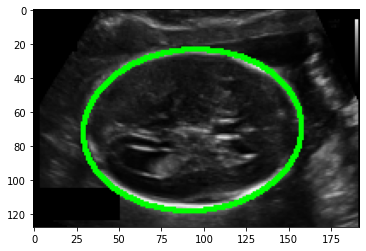

In [17]:
show_img_mask(img, mask)

### Split data into train validation

In step 4, we created two lists of train_index and val_index by separating 20 percent of
the indices from the total indices.

In [18]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=range(len(fetal_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

800
----------
200


In step 5, we passed the train_index and val_index to the Subset class from
the torch.utils.data package to create the training and validation datasets,
respectively.

In [19]:
from torch.utils.data import Subset

train_ds=Subset(fetal_ds1,train_index)
print(len(train_ds))

val_ds=Subset(fetal_ds2,val_index)
print(len(val_ds))

800
200


In step 6, we displayed the sample image and mask from train_ds and val_ds,
respectively.

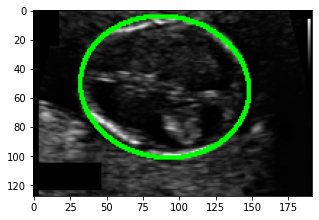

In [20]:
plt.figure(figsize=(5,5))
for img,mask in train_ds:
    show_img_mask(img,mask)
    break

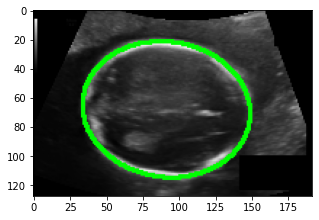

In [21]:
plt.figure(figsize=(5,5))
for img,mask in val_ds:
    show_img_mask(img,mask)
    break

### Creating DataLoader

In step 7, we defined two data loaders, train_dl, and val_dl, using the DataLoader
class to be able to fetch data batches from the training and validation datasets during
training.

In [22]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False) 

In step 8, we got a data batch from train_dl and val_dl, and printed their respective
shapes. As we saw, tensors of size [batch_size, 128, 192] were returned from the
data loaders.

In [23]:
for img_b, mask_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32


In [24]:
for img_b, mask_b in val_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([16, 1, 128, 192]) torch.float32
torch.Size([16, 1, 128, 192]) torch.float32


In [ ]:
torch.max(img_b)

## Creating the Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:

class SegNet(nn.Module):
    def __init__(self, params):
        super(SegNet, self).__init__()
        
        C_in, H_in, W_in=params["input_shape"]
        init_f=params["initial_filters"] 
        num_outputs=params["num_outputs"] 

        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3,padding=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up1 = nn.Conv2d(16*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv_up2 = nn.Conv2d(8*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv_up3 = nn.Conv2d(4*init_f, 2*init_f, kernel_size=3,padding=1)
        self.conv_up4 = nn.Conv2d(2*init_f, init_f, kernel_size=3,padding=1)

        self.conv_out = nn.Conv2d(init_f, num_outputs , kernel_size=3,padding=1)    
    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv5(x))

        x=self.upsample(x)
        x = F.relu(self.conv_up1(x))

        x=self.upsample(x)
        x = F.relu(self.conv_up2(x))
        
        x=self.upsample(x)
        x = F.relu(self.conv_up3(x))
        
        x=self.upsample(x)
        x = F.relu(self.conv_up4(x))

        x = self.conv_out(x)
        
        return x 

In [ ]:
params_model={
        "input_shape": (1,h,w),
        "initial_filters": 16, 
        "num_outputs": 1,
            }

model = SegNet(params_model)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

In [ ]:
print(model)

In [ ]:
from torchsummary import summary
summary(model, input_size=(1, h, w))

## Define Loss Function

In [ ]:
def dice_loss(pred, target, smooth = 1e-5):

    intersection = (pred * target).sum(dim=(2,3))
    union= pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) 
    
    dice= 2.0 * (intersection + smooth) / (union+ smooth)    
    loss = 1.0 - dice
    
    return loss.sum(), dice.sum()

In [ ]:

import torch.nn.functional as F

def loss_func(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target,  reduction='sum')
    
    pred= torch.sigmoid(pred)
    dlv, _ = dice_loss(pred, target)
    
    loss = bce  + dlv

    return loss

In [ ]:
for img_v,mask_v in val_dl:
    mask_v= mask_v[8:]
    break

for img_t,mask_t in train_dl:
    break
    


print(dice_loss(mask_v,mask_v))
loss_func(mask_v,torch.zeros_like(mask_v))


In [ ]:
import torchvision

def metrics_batch(pred, target):
    pred= torch.sigmoid(pred)
    _, metric=dice_loss(pred, target)
    
    return metric

In [ ]:
def loss_batch(loss_func, output, target, opt=None):   
    loss = loss_func(output, target)
    
    pred= torch.sigmoid(output)
    _, metric_b=dice_loss(pred, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

## Optimizer

In [ ]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [ ]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

## Training the Model

In [ ]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        
        output=model(xb)
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        
        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break
    
    loss=running_loss/float(len_data)
    
    metric=running_metric/float(len_data)
    
    return loss, metric

In [ ]:
import copy
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": []}
    
    metric_history={
        "train": [],
        "val": []}    
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
       
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            
        print("train loss: %.6f, dice: %.2f" %(train_loss,100*train_metric))
        print("val loss: %.6f, dice: %.2f" %(val_loss,100*val_metric))
        print("-"*10) 
        

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history        


In [ ]:
opt = optim.Adam(model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights.pt",
}

model,loss_hist,metric_hist=train_val(model,params_train)

In [ ]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [ ]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()